In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn import neighbors
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import scale
%matplotlib inline
sns.set_style('whitegrid')


In [19]:
# import data

df = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
df.head(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [20]:
df = df.drop(['Cabin','Name'], axis =1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


The age is missing a significant amount of values but we want to use it in the model, we will use Sibsp to estimate the age.\

Cabin is missing too many values to be useful,\
Name is a label atrribute. making these two columns expendable.


<AxesSubplot:xlabel='SibSp', ylabel='Age'>

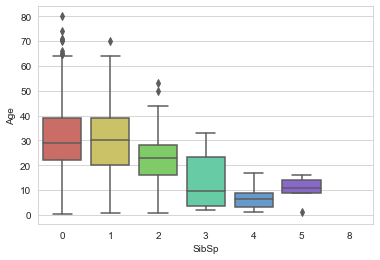

In [22]:
# A significant amount of Age entries are missing. The age of missing Age entries is estimated
# using the PSibSp categorical feature

sns.boxplot(x='SibSp', y ='Age',data=df,palette='hls')

In [23]:
Sibsp_groups = df.groupby(df['SibSp'])
Sibsp_groups.mean()

,PassengerId,Survived,Pclass,Age,Parch,Fare
SibSp,,,,,,
0,455.370066,0.345395,2.351974,31.397558,0.185855,25.692028
1,439.727273,0.535885,2.057416,30.089727,0.655502,44.147370
2,412.428571,0.464286,2.357143,22.620000,0.642857,51.753718
3,321.562500,0.250000,2.562500,13.916667,1.312500,68.908862
4,381.611111,0.166667,3.000000,7.055556,1.500000,31.855556
5,336.800000,0.000000,3.000000,10.200000,2.000000,46.900000
8,481.714286,0.000000,3.000000,NaN,2.000000,69.550000


In [7]:
def age_approx_Sibsp(cols):
    '''
    Approximates the age of a passenger based on the number 
    of siblings/spouse onboard if passenger's age is not provided

    -----------------------------
    Parameters (columns):
    Age and sibsp columns

    ----------------------------
    Returns (int):
    Age of passengers
    '''
    Age =cols[0]
    sibsp=cols[1]
    
    if pd.isnull(Age):
        if sibsp == 0:
            return 31
        elif sibsp ==1:
            return 30
        elif sibsp ==2:
            return 23
        elif sibsp ==3:
            return 13
        else:
            return 29
        
    else:
        return Age
            

In [25]:
df['Age'] = df[['Age','SibSp']].apply(age_approx_Sibsp,axis = 1)

In [26]:
df = df.dropna()
#df.info()

In [27]:
#Converting gender to a binary feature
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = df['Sex']
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[0:5]
# 0 - female, 1 - male

array([1, 0, 0, 0, 1])

In [28]:
gender_cat_y = test_data['Sex']
gender_encoded_y = label_encoder.fit_transform(gender_cat_y)
gender_encoded_y[0:5]

array([1, 0, 1, 1, 0])

In [29]:
gender_Df = pd.DataFrame(gender_encoded,columns=['male_gender'])

In [30]:
# Converting embarked to a binary feature
embarked_cat = df['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)
embarked_encoded[0:10]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0])

In [31]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_binary = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_binary = embarked_binary.toarray()
locations = ['C','Q','S']
embarked_binary_DF = pd.DataFrame(embarked_binary, columns = locations)
embarked_binary_DF

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
884,0.0,0.0,1.0
885,0.0,0.0,1.0
886,0.0,0.0,1.0
887,1.0,0.0,0.0


In [32]:
# Intergrate the binary features with the original data
titanic = pd.concat([df,gender_Df,embarked_binary_DF],axis=1,verify_integrity=True)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    float64
 1   Survived     889 non-null    float64
 2   Pclass       889 non-null    float64
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    float64
 6   Parch        889 non-null    float64
 7   Ticket       889 non-null    object 
 8   Fare         889 non-null    float64
 9   Embarked     889 non-null    object 
 10  male_gender  889 non-null    float64
 11  C            889 non-null    float64
 12  Q            889 non-null    float64
 13  S            889 non-null    float64
dtypes: float64(11), object(3)
memory usage: 104.4+ KB


<AxesSubplot:>

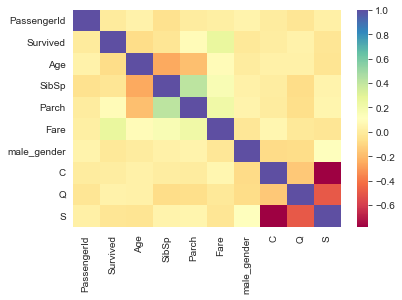

In [78]:
#Linear regression assumes predictors are independent of each so we want to drop all dependent features

sns.heatmap(titanic.corr(),cmap=sns.color_palette('Spectral',as_cmap=True))
# Pclass and Fare have a high correlation

In [34]:
# drop all label features of the dataset and the features that have been converted to binary form
titanic = titanic.drop(['Pclass','Sex','Embarked','Ticket'],axis=1)
titanic.head(5)

,PassengerId,Survived,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1.0,0.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


In [35]:
titanic.isnull().sum()

PassengerId    2
Survived       2
Age            2
SibSp          2
Parch          2
Fare           2
male_gender    2
C              2
Q              2
S              2
dtype: int64

In [36]:
titanic = titanic.dropna()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 888
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  887 non-null    float64
 1   Survived     887 non-null    float64
 2   Age          887 non-null    float64
 3   SibSp        887 non-null    float64
 4   Parch        887 non-null    float64
 5   Fare         887 non-null    float64
 6   male_gender  887 non-null    float64
 7   C            887 non-null    float64
 8   Q            887 non-null    float64
 9   S            887 non-null    float64
dtypes: float64(10)
memory usage: 76.2 KB


In [38]:
features = ['PassengerId','Fare','SibSp','Parch','Age','male_gender','C','Q','S']

In [39]:
X_train,X_test, y_train,y_test = train_test_split(titanic[features],titanic['Survived'], 
                                                  test_size = 0.2)


In [40]:
#scale training data
X_train,X_test = scale(X_train),scale(X_test)

In [41]:
Sibsp_groups = test_data.groupby(df['SibSp'])
Sibsp_groups.mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
SibSp,,,,,,
0.0,1105.851986,2.296029,30.029626,0.386282,0.368231,33.516953
1.0,1098.357143,2.204082,31.584321,0.683673,0.428571,38.853359
2.0,1093.615385,2.307692,30.727273,0.307692,0.769231,41.210262
3.0,1057.727273,2.363636,29.277778,0.454545,0.545455,43.771973
4.0,1056.363636,1.909091,28.444444,0.363636,0.000000,21.540536
5.0,1064.000000,2.333333,27.000000,0.000000,0.000000,92.681933
8.0,1108.000000,2.250000,23.832500,0.000000,1.000000,63.128125


In [42]:
test_data['Age'] = test_data[['Age','Parch']].apply(age_approx_Sibsp,axis = 1)

In [43]:
gender_Df_y = pd.DataFrame(gender_encoded_y,columns=['male_gender'])


embarked_cat_y = test_data['Embarked']
embarked_encoded_y = label_encoder.fit_transform(embarked_cat_y)
print(embarked_encoded_y[0:10])


embarked_binary_y = binary_encoder.fit_transform(embarked_encoded_y.reshape(-1,1))
embarked_binary_y = embarked_binary_y.toarray()
locations = ['C','Q','S']
embarked_binary_DF_y = pd.DataFrame(embarked_binary_y, columns = locations)
embarked_binary_DF_y

[1 2 1 2 2 2 1 2 0 2]


,C,Q,S
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
413,0.0,0.0,1.0
414,1.0,0.0,0.0
415,0.0,0.0,1.0
416,0.0,0.0,1.0


In [44]:
titanic_test = pd.concat([test_data,gender_Df_y,embarked_binary_DF_y],axis=1,verify_integrity=True)


titanic_test = titanic_test.drop(['Name','Pclass','Sex','Embarked','Ticket','Cabin'],axis=1)
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Age          418 non-null    float64
 2   SibSp        418 non-null    int64  
 3   Parch        418 non-null    int64  
 4   Fare         417 non-null    float64
 5   male_gender  418 non-null    int32  
 6   C            418 non-null    float64
 7   Q            418 non-null    float64
 8   S            418 non-null    float64
dtypes: float64(5), int32(1), int64(3)
memory usage: 27.9 KB


In [45]:
titanic_test = titanic_test.dropna()
#titanic_test.info()

In [46]:
#titanic_test.isnull().sum()

In [47]:

#Logistic Regressor Model
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train,y_train)

y_pred =LogReg.predict(X_train)
y_test_pred = LogReg.predict(X_test)
LogReg.score(X_test,y_test)


0.7134831460674157

In [48]:
print('Training Score')
print(classification_report(y_train,y_pred))
print('Testing Score')
print(classification_report(y_test,y_test_pred))

Training Score
              precision    recall  f1-score   support

         0.0       0.66      0.94      0.78       435
         1.0       0.72      0.23      0.35       274

    accuracy                           0.67       709
   macro avg       0.69      0.59      0.56       709
weighted avg       0.68      0.67      0.61       709

Testing Score
              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81       113
         1.0       0.82      0.28      0.41        65

    accuracy                           0.71       178
   macro avg       0.76      0.62      0.61       178
weighted avg       0.74      0.71      0.67       178



In [49]:
y_train_pred = cross_val_predict(LogReg,X_train,y_train,cv=5)
confusion_matrix(y_train,y_train_pred)

array([[401,  34],
       [214,  60]], dtype=int64)

In [50]:
y_test_mat = cross_val_predict(LogReg,X_test,y_test,cv=5)
confusion_matrix(y_test,y_test_mat)

array([[103,  10],
       [ 35,  30]], dtype=int64)

In [51]:
pred = LogReg.predict(titanic_test)
#print(pred)

In [52]:
survivors = pred.sum()
percentage =(pred.sum()/len(pred))*100
print(f'There are {survivors} survivors resulting in a {percentage:.2f}% survival rate')

There are 349.0 survivors resulting in a 83.69% survival rate


In [53]:
titanic_test['lg_Survived'] = pred
titanic_test.head()

,PassengerId,Age,SibSp,Parch,Fare,male_gender,C,Q,S,lg_Survived
0,892,34.5,0,0,7.8292,1,0.0,1.0,0.0,1.0
1,893,47.0,1,0,7.0000,0,0.0,0.0,1.0,1.0
2,894,62.0,0,0,9.6875,1,0.0,1.0,0.0,1.0
3,895,27.0,0,0,8.6625,1,0.0,0.0,1.0,1.0
4,896,22.0,1,1,12.2875,0,0.0,0.0,1.0,1.0


In [54]:
# KNeighbors

knc = neighbors.KNeighborsClassifier()
knc.fit(X_train,y_train)
y_pred = knc.predict(X_test)

In [55]:
knc.score(X_test,y_test)

0.7134831460674157

In [56]:
y_train_pred = cross_val_predict(knc,X_train,y_train,cv=5)
confusion_matrix(y_train,y_train_pred)

array([[364,  71],
       [152, 122]], dtype=int64)

In [57]:
y_test_mat = cross_val_predict(knc,X_test,y_test,cv=5)
confusion_matrix(y_test,y_test_mat)

array([[90, 23],
       [39, 26]], dtype=int64)

In [64]:
knc_pred = knc.predict(titanic_test.drop('lg_Survived',axis=1))

In [66]:
titanic_test['knc_survived'] = knc_pred

In [67]:
titanic_test.head()

,PassengerId,Age,SibSp,Parch,Fare,male_gender,C,Q,S,lg_Survived,knc_survived
0,892,34.5,0,0,7.8292,1,0.0,1.0,0.0,1.0,1.0
1,893,47.0,1,0,7.0000,0,0.0,0.0,1.0,1.0,1.0
2,894,62.0,0,0,9.6875,1,0.0,1.0,0.0,1.0,1.0
3,895,27.0,0,0,8.6625,1,0.0,0.0,1.0,1.0,0.0
4,896,22.0,1,1,12.2875,0,0.0,0.0,1.0,1.0,0.0
